# HIDRA Sea Level Prediction

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from hidra import HIDRA, add_inference_head
from hidra.data import DataNormalization

**Step 1**: Read the data

In [3]:
with h5py.File('../data/example_data.hdf5', 'r') as ds:
    # Atmospheric data
    atmospheric_data = ds['weather'][:]
    
    # Sea level data (residuals and tide)
    residuals = ds['delta'][...,0]
    tides = ds['tide'][...,0]
    sea_level_data = np.stack([residuals, tides], axis=-1)
    
    # Labels (total heights and tide)
    labels_total = ds['lbl_ssh'][...,0]
    labels_tide = ds['lbl_tide'][...,0]

In [4]:
atmospheric_data.shape, sea_level_data.shape, labels_total.shape

((5, 24, 29, 37, 4), (5, 24, 2), (5, 72))

**Step 2**: Load the HIDRA model

In [5]:
model = HIDRA()

# Input an example to initialize the network and load weights
res = model((atmospheric_data[:1], sea_level_data[:1]))
model.load_weights('../models/HIDRA_Koper.hdf5')

# Add inference head to the model (output means and confidence intervals)
model = add_inference_head(model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



**Step 3**: Run inference

In [6]:
# Run inference
preds = model.predict((atmospheric_data, sea_level_data))

# Get predicted means and confidence intervals
pred_means = preds[...,0]
pred_stds = preds[...,1]

Consider rewriting this model with the Functional API.


In [7]:
# Destandardize the data
norm = DataNormalization('../data/summary.json')

# Add tide and destandardize
pred_means_total = pred_means + labels_tide
pred_means_total = norm.denormalize_ssh(pred_means_total)
pred_stds = pred_stds * norm.summary['ssh'][1] # Scale confidence interval

labels_total = norm.denormalize_ssh(labels_total)

## Predictions visualization

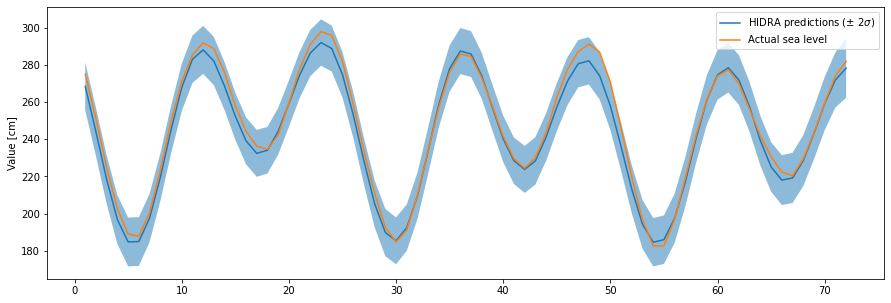

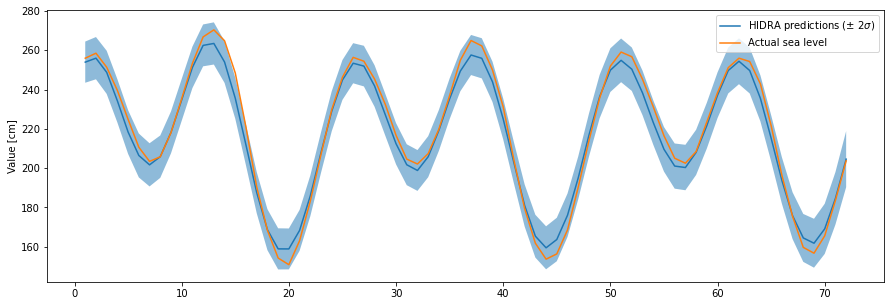

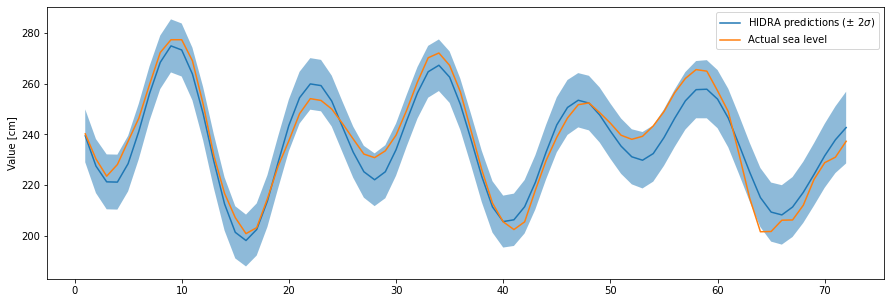

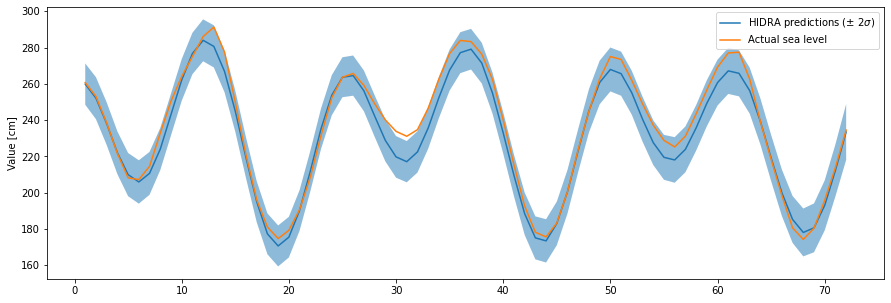

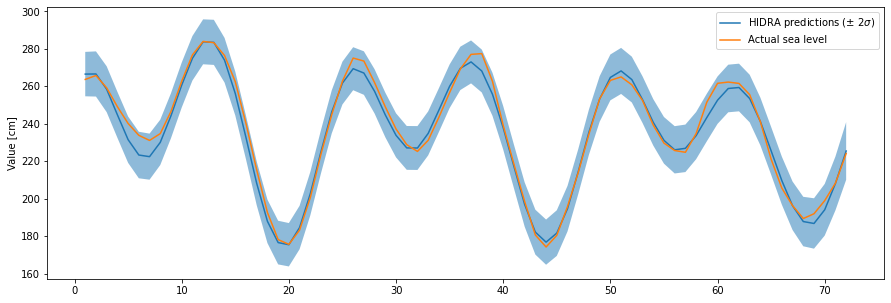

In [8]:
for i in range(5):
    plt.figure(figsize=(15,5))
    x = np.arange(1, 73)
    plt.plot(x, pred_means_total[i])
    plt.plot(x, labels_total[i])
    plt.fill_between(x, pred_means_total[i]-2*pred_stds[i],pred_means_total[i]+2*pred_stds[i], alpha=0.5)
    plt.legend(['HIDRA predictions ($\pm$ $2\sigma$)', 'Actual sea level'])
    plt.ylabel('Value [cm]')